# 1. Probabilistic dynamic motion primitives.

Extension to DMP in probabilistic sense. 

# 2. Key Papers.

1. Paraschos et al.: Probabilistic movement primitives, NeurIPS (2013),
    https://papers.nips.cc/paper/2013/file/e53a0a2978c28872a4505bdb51db06dc-Paper.pdf

2. Maeda et al.: Probabilistic movement primitives for coordination of
    multiple human–robot collaborative tasks, AuRo 2017,
    https://link.springer.com/article/10.1007/s10514-016-9556-2

3. Paraschos et al.: Using probabilistic movement primitives in robotics, AuRo (2018),
    https://www.ias.informatik.tu-darmstadt.de/uploads/Team/AlexandrosParaschos/promps_auro.pdf,
    https://link.springer.com/article/10.1007/s10514-017-9648-7

4. Lazaric et al.: Bayesian Multi-Task Reinforcement Learning, ICML (2010),
    https://hal.inria.fr/inria-00475214/document

# 3. Toy problem.

3.1. Generation of artificial 2-dim data, representing some curves in 2d. Based on expert's trajectories we want to learn how to draw something.  They are used to initialize probabilistic DMP. "True" trajectory is painted in red.

In [22]:
import sys
sys.path.append('../movement_primitives/')
import numpy as np
import matplotlib.pyplot as plt

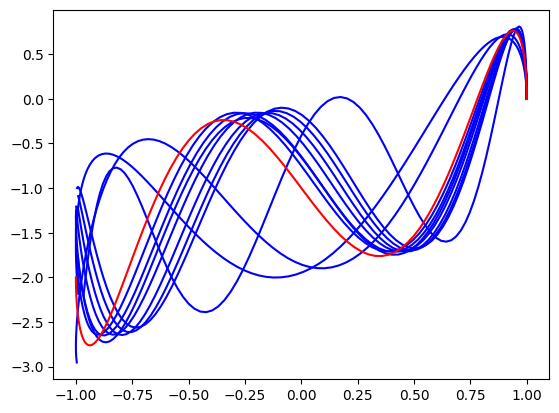

In [23]:
n_steps = 100
n_demos = 10
dimensionality = 2
# potentially each trajectory could be sampled at different timestamps
TT = np.array([np.linspace(0, 1, n_steps) for _ in range(n_demos)])
def generate_2d_demo(n_steps, demo_idx, X_noise=0.05, Y_noise=0.1):
    r1 = np.random.randn() * X_noise
    r2 = np.random.randn() * Y_noise
    time = TT[demo_idx,:]    
    X = np.ndarray((n_steps, dimensionality))
    
    X[:, 0] = np.cos((1+r1) * np.pi*time)
    X[:, 1] = np.sin((1+r2) * 4*np.pi*time)-2*np.linspace(0, 1, n_steps)    
    return X
# True median trajectory
fact = np.ndarray((n_steps, dimensionality))
fact[:, 0] = np.cos(np.pi*TT[0,:])
fact[:, 1] = np.sin(4*np.pi*TT[0,:])-2*np.linspace(0, 1, n_steps)


demos = np.array([generate_2d_demo(n_steps,demo_idx) for demo_idx in range(n_demos)])
#test_trajectory = np.array([generate_demo(n_steps,demo_idx) for demo_idx in range(2)])
for demo in demos:
    plt.plot(demo[:, 0], demo[:, 1], color="b")
    
plt.plot(fact[:, 0], fact[:, 1], color="r")
#plt.plot(test_trajectory[:, 0], test_trajectory[:, 1], color="g")

Initialize probabilistic MDP object.

In [24]:
from promp import ProMP
n_weights_per_dim = 50
promp = ProMP(n_dims=dimensionality, n_weights_per_dim=n_weights_per_dim)

In [25]:
demos.shape

(10, 100, 2)

In [26]:
TT.shape

(10, 100)

Fit probabilistic DMP to generated trajectories.

In [27]:
promp.imitate(TT, demos, verbose=1)

Iteration 0001: delta = 1.81107
Iteration 0002: delta = 8.43915
Iteration 0003: delta = 0.172501
Iteration 0004: delta = 0.000232076
Iteration 0005: delta = 4.1647e-07


Generate new samples of trajectories by using probabilistic DMPs.  Compute mean trajectory and variance for them. Use one trajsctory(painted in black) as a testing trajectory to compute similarity score.

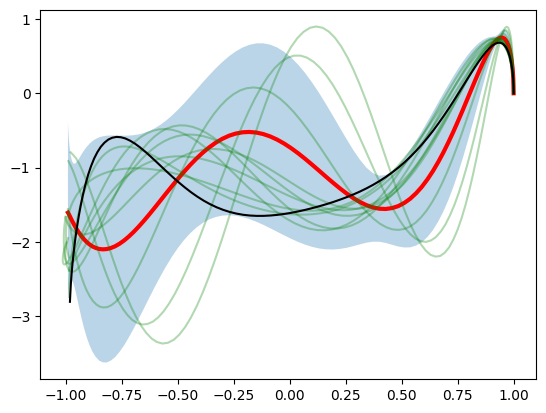

In [28]:
random_state = np.random.RandomState(1)
samples = promp.sample_trajectories(TT[0], 10, random_state)

mean_trajectory = promp.mean_trajectory(TT[0])
plt.plot(mean_trajectory[:,0], mean_trajectory[:,1], label="Reproduction", c="r", lw=3)
var_trajectory = np.sqrt(promp.var_trajectory(TT[0]))
factor = 2
plt.fill_between(
        mean_trajectory[:, 0],
        mean_trajectory[:, 1] - factor * var_trajectory[:, 1],
        mean_trajectory[:, 1] + factor * var_trajectory[:, 1],
        alpha=0.3)
for sample in samples:
    plt.plot(sample[:,0], sample[:,1], c="g", alpha=0.3)
    
random_state = np.random.RandomState(35)
test_trajectory = promp.sample_trajectories(TT[0], 1, random_state)
plt.plot(test_trajectory[0,:,0], test_trajectory[0,:,1], c="black")
plt.show()

Define a score function, representing a measure of deviation of the tested trajectory from the mean trajectory.
In particular: if tested traiectory is beyond a specified threshould in terms of variance from the mean trajectory, we penelize the perfect score.

In [29]:
def similarity_score(test_sample, mean_trajectory, var_trajectory, threshold=2.0):
    deviation = test_sample - mean_trajectory
    factors = np.abs(deviation)/(var_trajectory)
    avg_extreme = np.sum([factors>threshold])/(factors.shape[1]*factors.shape[0])
    return 1 - avg_extreme

In [30]:
score = similarity_score(test_trajectory[0], mean_trajectory, var_trajectory)
print(f"Current score : {score}")

Current score : 1.0


# 4. Experiment with real dataset.

In [31]:
import c3d
from scipy.signal import savgol_filter

In experiment below the same person demonstrates a "hand waiving" in 4 different attempts, and we use this data to
initialize probabilistic DMP. 5th attempt from the same person and  one attempt from some other person are used to test scoring function we devise based on probDMP. While the similarity score for the same person should be close to being perfect, the score relevant to the other person's attempt could be much smaller, because it is a different performer.

Load sensor data of person, waiving one hand from :
https://tele-immersion.citris-uc.org/berkeley_mhad#mvmts


In [32]:
data_file_path_template = "../dataset/moc_s0{}_a06_r0{}.c3d"    
train_files_expert = [data_file_path_template.format(str(1),str(idx)) for idx in range(1,5)]
test_file_expert = [data_file_path_template.format(str(1),str(5))]
test_file_student = [data_file_path_template.format(str(2), str(1))]

In [64]:
# indices of links inside of dataset
head = 0
back = np.arange(3, 7)
left_hand = np.arange(11, 19)
right_hand = [19, 20, 21, 22, 24]
left_leg = [27, 28, 30, 31, 32, 33, 34]
right_leg = [35, 37, 38, 39, 40, 41, 42]
dimensionality = 3
# TODO: need to work on subsampling from real data. Extracted data samples should be synchronized in time, 
# and basically represent the same motion. These dataset is not synchronized.
def prepare_3d_data(file_paths, sample_size=600):
    """Extract sensor data from files, subsample, replicate 3 times and smooth. """
    
    n_demos = len(file_paths)
    n_steps = 3 * sample_size 
    tt = np.array([np.linspace(0, 1, n_steps) for _ in range(n_demos)])
    data_ret = np.ndarray((n_demos, n_steps, dimensionality))
    for file_index, file_path in enumerate(file_paths):
        reader = c3d.Reader(open(file_path, 'rb'))
        data = reader.read_frames()
        data = list(data)

        data = [data[i][1][:, 0:3] for i in range(np.int(np.ceil(len(data))))]
        data = np.array(data)

        # Sample and smooth
        data = data[1000:1000+sample_size]
        data = np.concatenate((data, data, data))

        data = savgol_filter(data, 401, 3, axis=0)
        data = savgol_filter(data, 401, 3, axis=0)
        # make all values positive
        data += 1000
        # Trajectory of human's hand
        traj_x = data[:, right_hand[-1], 0]
        traj_y = data[:, right_hand[-1], 1]
        traj_z = data[:, right_hand[-1], 2]
        # Adjust initial coordinates
        traj_x = traj_x - traj_x[0]
        traj_y = traj_y - traj_y[0]
        traj_z = traj_z - traj_z[0]
        data_ret[file_index,:,0] = traj_x
        data_ret[file_index,:,1] = traj_y
        data_ret[file_index,:,2] = traj_z
        
    return tt, data_ret
        

In [34]:
time_steps_train_expert, data_3d_train_expert = prepare_3d_data(train_files_expert)

/tmp/ipykernel_211139/1526620342.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = [data[i][1][:, 0:3] for i in range(np.int(np.ceil(len(data))))]


In [35]:
data_3d_train_expert.shape

(4, 1800, 3)

In [36]:
_, data_3d_test_expert = prepare_3d_data(test_file_expert)
_, data_3d_test_student = prepare_3d_data(test_file_student)

/tmp/ipykernel_211139/1526620342.py:22: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data = [data[i][1][:, 0:3] for i in range(np.int(np.ceil(len(data))))]


In [37]:
data_3d_test_expert.shape

(1, 1800, 3)

# 5. Learn quasi-periodic 3D trajectory from demonstration.

In [38]:
def plot_trajectory(trajectory_data):
    traj_x = trajectory_data[:,0]
    traj_y = trajectory_data[:,1]
    traj_z = trajectory_data[:,2]
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(range(traj_x.shape[0]), traj_x, label="X coordinate")
    ax2 = ax.twinx()
    ax2.spines["right"].set_edgecolor("orange")
    ax2.tick_params(axis='y', colors="orange")
    ax2.plot(range(traj_y.shape[0]), traj_y, label="Y coordinate", c="orange")
    ax3 = ax.twinx()
    ax3.spines["right"].set_edgecolor("green")
    ax3.tick_params(axis='y', colors="green")
    ax3.plot(range(traj_z.shape[0]), traj_z, label="Z coordinate", c="green")
    ax.legend(loc=(0.05, 0.9))
    ax2.legend(loc=(0.35, 0.9))
    ax3.legend(loc=(0.7, 0.9))
    ax.set_xlabel("Samples")
    plt.title("Demonstrated Trajetory")
    plt.show()

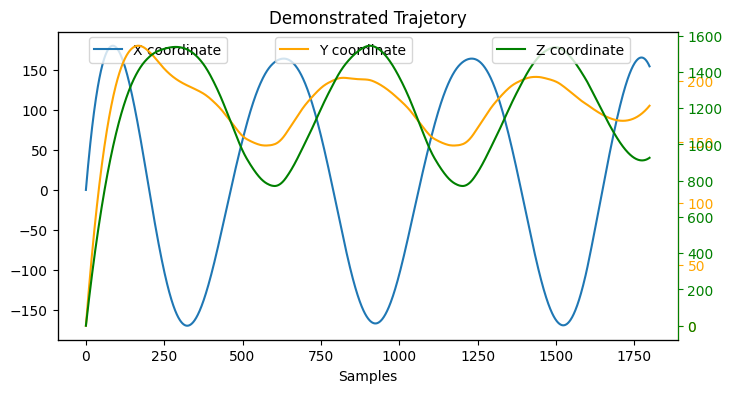

In [39]:
plot_trajectory(data_3d_train_expert[0])

In [40]:
def plot_2d_projection(data, proj_plane="XY"):
    """Plots projection of 3d sensor data on certain section plane
    Inputs:
    - data: shape (n_sample, n_dims)
    - XY,YZ,XZ - valid plane section"""
    plt.figure(figsize=(4, 4))
    x_idx, y_idx = 0,0
    if proj_plane =="XY" or proj_plane=='YX':
        x_idx = 0
        y_idx = 1
    elif proj_plane=="YZ" or proj_plane=="ZY":
        x_idx = 1
        y_idx = 2
    elif proj_plane=="XZ" or proj_plane=="ZX":
        x_idx = 0
        y_idx = 2
    else:
        print("Please specify correct plane")
    traj_x = data[:,x_idx]
    traj_y = data[:,y_idx]    
    plt.scatter([traj_x[0]], [traj_y[0]], c="k")
    plt.scatter([traj_x[-1]], [traj_y[-1]], c="r")
    plt.plot(traj_x, traj_y, c="k", linestyle="--")
    plt.show()
        

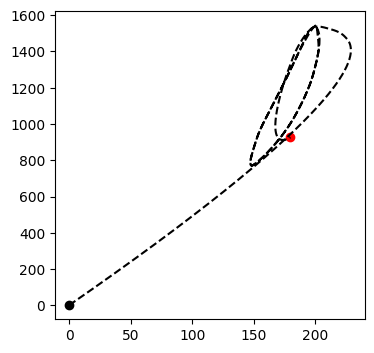

In [41]:
plot_2d_projection(data_3d_train_expert[0], "YZ")

Fit Probabilistic DMP to the trajectories. 

In [42]:
n_weights_per_dim = 500
promp = ProMP(n_dims=dimensionality, n_weights_per_dim=n_weights_per_dim)

Imitate expert's trajectories by using Probabilistic DMP.

In [43]:
promp.imitate(time_steps_train_expert, data_3d_train_expert, verbose=1)

Iteration 0001: delta = 2118.9
Iteration 0002: delta = 5840.07
Iteration 0003: delta = 1700.37
Iteration 0004: delta = 17.0208
Iteration 0005: delta = 0.00172035
Iteration 0006: delta = 0.000308847
Iteration 0007: delta = 5.33094e-11


In [44]:
mean_trajectory = promp.mean_trajectory(time_steps_train_expert[0])
var_trajectory = np.sqrt(promp.var_trajectory(time_steps_train_expert[0]))

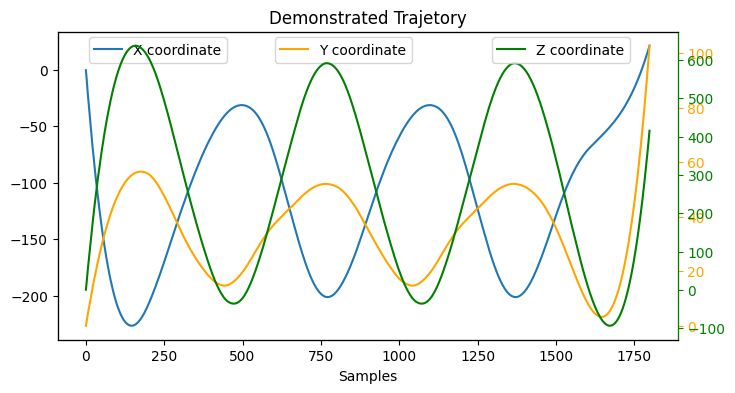

In [63]:
plot_trajectory(mean_trajectory)

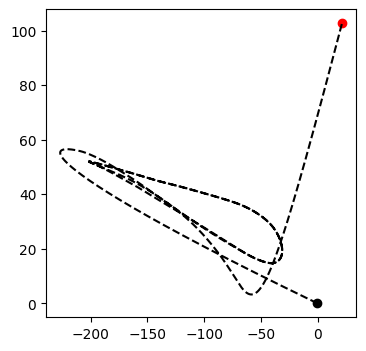

In [46]:
plot_2d_projection(mean_trajectory)

# 6. Conclusion.

Basically this approach would work in 3d case and with real data. The only problem with dataset used that it is not synchronized in time and requires a manual picking of the sample start in separate files, so that it would reprsent the same physical action. 